In [24]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from scf_guess_tools import Backend

BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"
GEOMETRY_Source = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="density",
                       data_aug_factor=3,
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:02<00:00, 213.24it/s]
Creating graphs: 500it [00:07, 64.84it/s]


Augmenting training set by factor 3 -> 800 additional training samples.


Augmenting data: 100%|██████████| 800/800 [01:46<00:00,  7.51it/s]


Total samples: 1300, Train: 1200 (with 800 / 1200 augmented samples), Val: 50, Test: 50
Found 3 center keys (['C', 'H', 'O']) and 6 edge keys (['C_C', 'C_H', 'C_O', 'H_H', 'H_O', 'O_O']) in the training set. -> Totaling 9 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.2721039375810203), 'H': (0.3772194703420003, 0.468965563609298), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0008618056455612818, 0.058571427922486985), 'C_H': (0.003466914974277336, 0.06588487434420423), 'C_O': (0.00035369045656090647, 0.04551374111736355), 'H_H': (0.0060299485124611025, 0.03683429578058327), 'H_O': (0.0011144057180675875, 0.03490926799392169), 'O_O': (-6.281023443982128e-05, 0.011447899704817495)}
First train batch: 304 atoms, 4940 edges, 304 center blocks.
Found center block size 351 for atom type O.
Found center block size 351 for atom type C.
Found center block size 15 for atom type H.
Found edge block size 6

In [25]:
RETRAIN = False
model_name = "MGNN_6-31G_simple_AUG"
if not RETRAIN and os.path.exists(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=100, lr=1e-3, weight_decay=1e-5, model_save_path=f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.pth")

Epoch 1 [Train]: 100%|██████████| 75/75 [01:46<00:00,  1.42s/it]


Epoch 1/100 → Avg Train Loss: 142.118013


Epoch 1 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s]


Epoch 1/100 → Avg Val   Loss: 99.590178
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 2 [Train]: 100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


Epoch 2/100 → Avg Train Loss: 93.452740


Epoch 2 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch 2/100 → Avg Val   Loss: 90.924063
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 3 [Train]: 100%|██████████| 75/75 [01:52<00:00,  1.50s/it]


Epoch 3/100 → Avg Train Loss: 88.219671


Epoch 3 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.29it/s]


Epoch 3/100 → Avg Val   Loss: 88.162453
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 4 [Train]: 100%|██████████| 75/75 [01:50<00:00,  1.48s/it]


Epoch 4/100 → Avg Train Loss: 86.339323


Epoch 4 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch 4/100 → Avg Val   Loss: 86.954756
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 5 [Train]: 100%|██████████| 75/75 [01:52<00:00,  1.50s/it]


Epoch 5/100 → Avg Train Loss: 85.167571


Epoch 5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


Epoch 5/100 → Avg Val   Loss: 85.956987
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 6 [Train]: 100%|██████████| 75/75 [01:49<00:00,  1.46s/it]


Epoch 6/100 → Avg Train Loss: 84.118631


Epoch 6 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch 6/100 → Avg Val   Loss: 84.939896
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 7 [Train]: 100%|██████████| 75/75 [01:56<00:00,  1.56s/it]


Epoch 7/100 → Avg Train Loss: 82.949090


Epoch 7 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


Epoch 7/100 → Avg Val   Loss: 83.886747
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 8 [Train]: 100%|██████████| 75/75 [01:55<00:00,  1.54s/it]


Epoch 8/100 → Avg Train Loss: 81.910844


Epoch 8 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 8/100 → Avg Val   Loss: 83.004814
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 9 [Train]: 100%|██████████| 75/75 [01:54<00:00,  1.52s/it]


Epoch 9/100 → Avg Train Loss: 81.127146


Epoch 9 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


Epoch 9/100 → Avg Val   Loss: 82.557734
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 10 [Train]: 100%|██████████| 75/75 [02:00<00:00,  1.61s/it]


Epoch 10/100 → Avg Train Loss: 80.632985


Epoch 10 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch 10/100 → Avg Val   Loss: 82.274012
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 11 [Train]: 100%|██████████| 75/75 [01:57<00:00,  1.57s/it]


Epoch 11/100 → Avg Train Loss: 80.264881


Epoch 11 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]


Epoch 11/100 → Avg Val   Loss: 82.102585
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 12 [Train]: 100%|██████████| 75/75 [01:57<00:00,  1.57s/it]


Epoch 12/100 → Avg Train Loss: 79.975894


Epoch 12 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Epoch 12/100 → Avg Val   Loss: 81.813253
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 13 [Train]: 100%|██████████| 75/75 [02:03<00:00,  1.64s/it]


Epoch 13/100 → Avg Train Loss: 79.738875


Epoch 13 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Epoch 13/100 → Avg Val   Loss: 81.686693
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 14 [Train]: 100%|██████████| 75/75 [02:02<00:00,  1.63s/it]


Epoch 14/100 → Avg Train Loss: 79.541086


Epoch 14 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


Epoch 14/100 → Avg Val   Loss: 81.508715
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 15 [Train]: 100%|██████████| 75/75 [02:00<00:00,  1.60s/it]


Epoch 15/100 → Avg Train Loss: 79.329241


Epoch 15 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Epoch 15/100 → Avg Val   Loss: 81.438625
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 16 [Train]: 100%|██████████| 75/75 [02:02<00:00,  1.63s/it]


Epoch 16/100 → Avg Train Loss: 79.121326


Epoch 16 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


Epoch 16/100 → Avg Val   Loss: 81.359966
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 17 [Train]: 100%|██████████| 75/75 [02:01<00:00,  1.62s/it]


Epoch 17/100 → Avg Train Loss: 78.950733


Epoch 17 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 17/100 → Avg Val   Loss: 81.268087
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 18 [Train]: 100%|██████████| 75/75 [02:00<00:00,  1.60s/it]


Epoch 18/100 → Avg Train Loss: 78.805551


Epoch 18 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


Epoch 18/100 → Avg Val   Loss: 81.111500
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 19 [Train]: 100%|██████████| 75/75 [02:05<00:00,  1.67s/it]


Epoch 19/100 → Avg Train Loss: 78.671113


Epoch 19 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Epoch 19/100 → Avg Val   Loss: 81.127594


Epoch 20 [Train]: 100%|██████████| 75/75 [02:05<00:00,  1.67s/it]


Epoch 20/100 → Avg Train Loss: 78.553429


Epoch 20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


Epoch 20/100 → Avg Val   Loss: 80.800484
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 21 [Train]: 100%|██████████| 75/75 [02:09<00:00,  1.72s/it]


Epoch 21/100 → Avg Train Loss: 78.444430


Epoch 21 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Epoch 21/100 → Avg Val   Loss: 81.022760


Epoch 22 [Train]: 100%|██████████| 75/75 [02:06<00:00,  1.69s/it]


Epoch 22/100 → Avg Train Loss: 78.349883


Epoch 22 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]


Epoch 22/100 → Avg Val   Loss: 80.577602
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 23 [Train]: 100%|██████████| 75/75 [02:06<00:00,  1.69s/it]


Epoch 23/100 → Avg Train Loss: 78.257179


Epoch 23 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch 23/100 → Avg Val   Loss: 80.803917


Epoch 24 [Train]: 100%|██████████| 75/75 [02:06<00:00,  1.68s/it]


Epoch 24/100 → Avg Train Loss: 78.175990


Epoch 24 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Epoch 24/100 → Avg Val   Loss: 80.562109
Model checkpoint saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 25 [Train]: 100%|██████████| 75/75 [02:09<00:00,  1.72s/it]


Epoch 25/100 → Avg Train Loss: 78.097656


Epoch 25 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Epoch 25/100 → Avg Val   Loss: 80.844505


Epoch 26 [Train]: 100%|██████████| 75/75 [02:16<00:00,  1.82s/it]


Epoch 26/100 → Avg Train Loss: 78.020354


Epoch 26 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch 26/100 → Avg Val   Loss: 80.645590


Epoch 27 [Train]: 100%|██████████| 75/75 [02:11<00:00,  1.76s/it]


Epoch 27/100 → Avg Train Loss: 77.943438


Epoch 27 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Epoch 27/100 → Avg Val   Loss: 80.706980
No improvement for 3 -> early stopping


Epoch 27 [Test]: 100%|██████████| 4/4 [00:00<00:00,  7.21it/s]


Test  Loss: 78.763973
Model saved to /home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


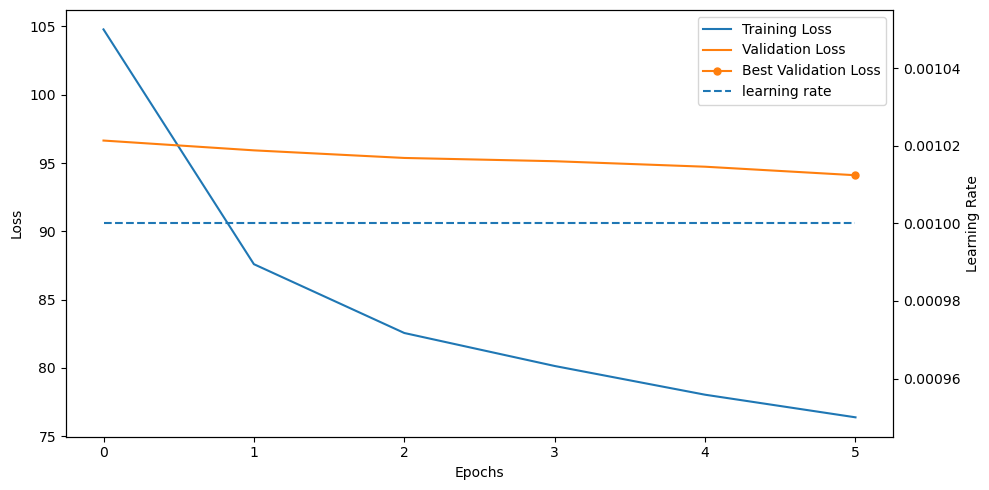

In [4]:
import pickle
from matplotlib import pyplot as plt
with open(f"/home/etschgi1/REPOS/Masterarbeit/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [5]:
test_graphs = MGNN.get_graphs("test")

In [22]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]

Testing on random sample with id 0


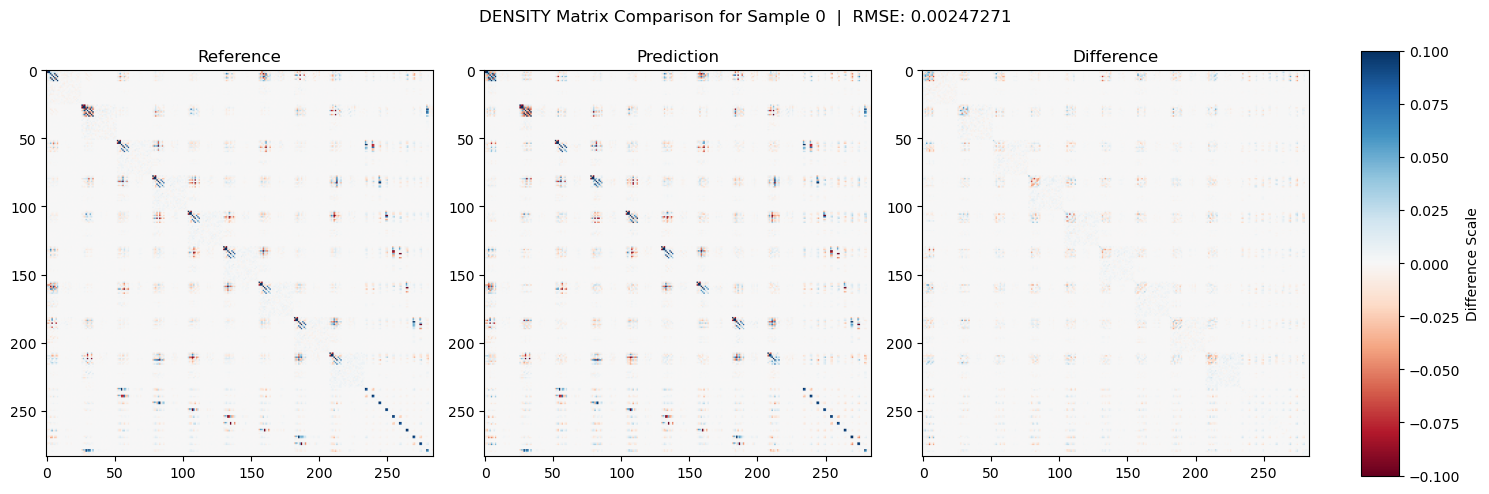

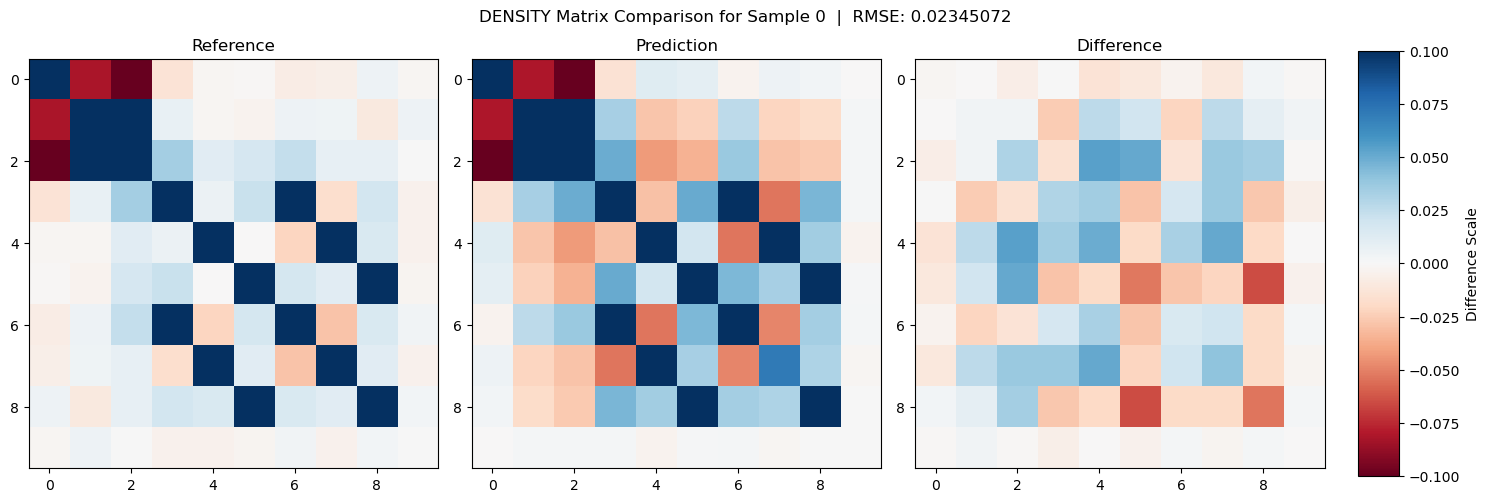

In [23]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [8]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [10]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_073475.xyz
Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.180734214149


In [11]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_pred)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.180734214038


In [13]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_truth)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.180734214137


In [14]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 11, cycles with own guess: 11, cycles with ground truth guess: 4


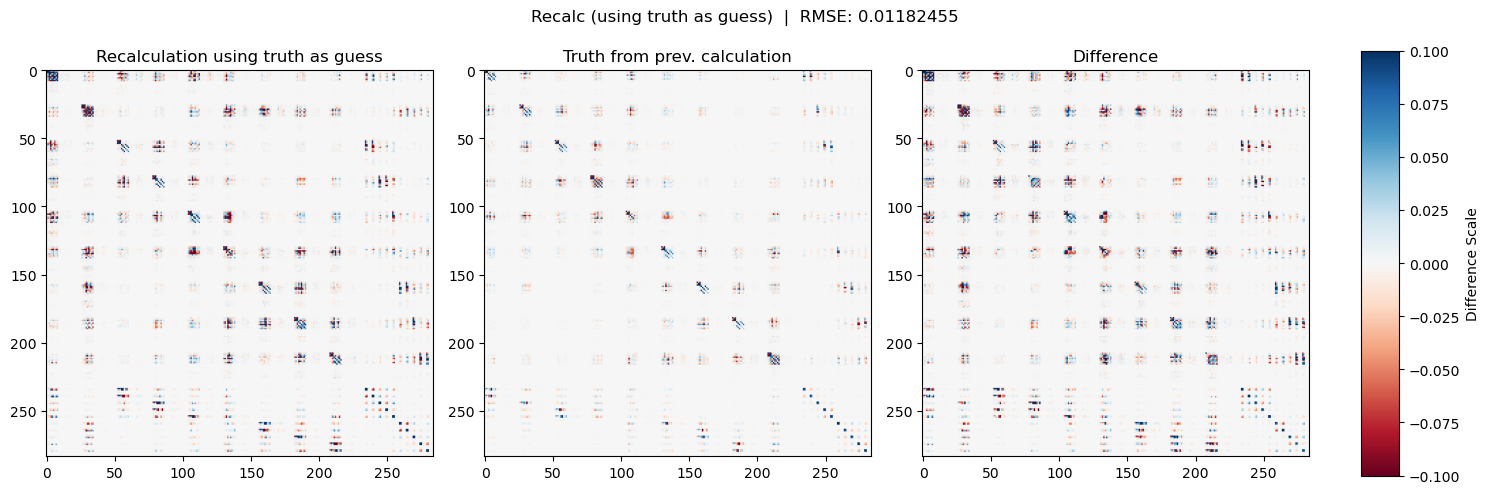

In [ ]:
plot_mat_comp(wf_minao._D, density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

#### look into difference of truth vs. recalc!

In [ ]:
import sys
sys.path.append('../src/')
from utils import density_fock_overlap
test_file = os.path.join(GEOMETRY_Source, "dsgdb9nsd_082759.xyz")
print(test_file)



/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted/dsgdb9nsd_082759.xyz


In [ ]:
mol = load(test_file, basis=BASIS_PATH, backend=Backend.PY)
minao_calc = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")


Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.141549838531


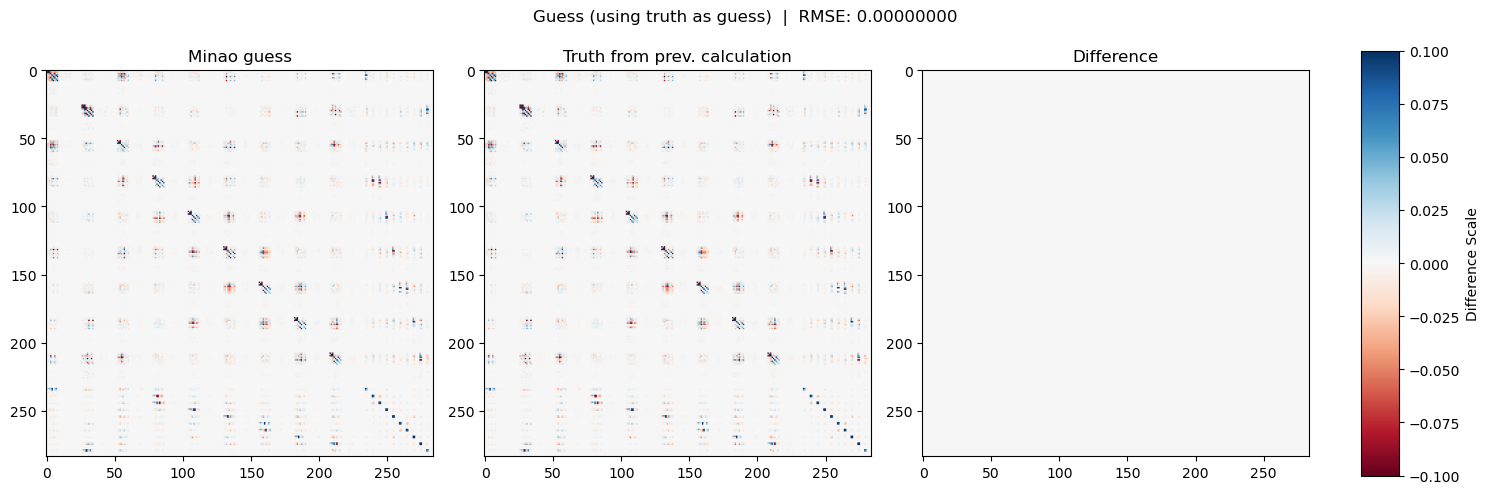

In [ ]:

cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"}
mol_name = os.path.basename(test_file).strip()
cached_truth = density_fock_overlap(filepath=test_file,
                                              filename = mol_name,
                                              method = cache_meta["method"],
                                              basis = None,
                                              functional = cache_meta["functional"],
                                              guess = cache_meta["guess"],
                                              backend = cache_meta["backend"],
                                              cache = cache_meta["cache"])
density_cached_truth = cached_truth[0].numpy
plot_mat_comp(minao_calc.density().numpy, density_cached_truth, title="Guess (using truth as guess)", ref_title="Minao guess", pred_title="Truth from prev. calculation", vmax=0.1)